# Flower Pollination Algorithm (FPA)

<a href="https://colab.research.google.com/github/glaucogoncalves/nio/blob/main/lectures/04_04_FPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  1. Introduction

The **Flower Pollination Algorithm (FPA)** is a population-based optimization method developed by Xin-She Yang (2012). Inspired by the pollination process in flowering plants, the algorithm models two main types of pollination — **biotic (cross-pollination)** and **abiotic (self-pollination)**.

**Key Features:**
- Few tuning parameters
- Robustness across various domains: image processing, classification, neural networks, engineering, etc
- Scalability to both low- and high-dimensional problems

## 2. Natural Pollination Process


### 2.1 Biotic Process (Cross-Pollination)

* Represents about **90%** of flowering plants
* Vectors include insects, birds, bats, bees, etc
* These pollinators can perform **long-distance flights** that follow **Lévy distributions**, characterized by occasional long jumps
* **Implication in FPA**: global search model

  $$
    x_i^{t+1} = x_i^t + \gamma\,L\,(g^* - x_i^t),
  $$

  where $L$ is a Lévy step generated using the Mantegna algorithm.


<img src="./figures/fpa-cross-polination.png" alt="drawing" width="450"/>

### 2.2 Abiotic Process or Self-Pollination

* Approximately **10%** of flowering plants.
* Pollen is transported by **wind** or **internal diffusion** between flowers of the same plant.
* Movements are always **short** and local.
* **Implication in FPA**: local search

  $$
    x_i^{t+1} = x_i^t + \varepsilon\,(x_j^t - x_k^t),\quad \varepsilon \sim U(0,1).
  $$


<img src="./figures/fpa-self-polination.png" alt="drawing" width="300"/>

### 2.3 Flower Constancy

* Pollinators tend to repeatedly visit the **same species** of flower, optimizing energy use and increasing pollination efficiency
* **In the algorithm**: this translates into a higher probability of crossover between similar solutions — using a similarity measure that favors local combinations of two nearby "flowers"


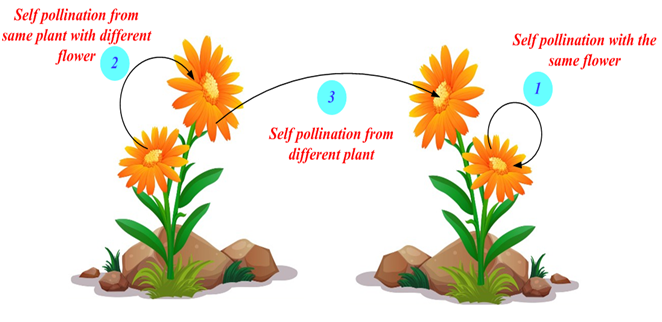

## 3. Fundamental Rules of FPA

| **Rule** | **Description** |
|----------|---------------------------------------------|
| **1. Biotic / Cross-Pollination → Global** | Biotic and cross-pollination are considered global pollination processes, where pollinators carrying pollen move according to *Lévy flight* trajectories. |
| **2. Abiotic / Self-Pollination → Local** | Local pollination is modeled using mechanisms such as abiotic pollination (by wind or gravity) and self-pollination. |
| **3. Flower Constancy** | Pollinators, such as insects, may develop *flower constancy*, which corresponds to a reproduction probability proportional to the similarity between two flowers. |
| **4. Switching Controlled by $p \in [0, 1]$** | The choice between local and global pollination is controlled by a switching probability $p$, usually biased slightly toward local pollination. |


## 4. Mathematical Model of FPA

1. **Global Pollination**

   Global pollination is modeled as a stochastic search process guided by the current best global solution $g^*$, with movements defined by Lévy flights:

   $$
   x_i^{t+1} = x_i^t + \gamma\,L(\lambda)\,(g^* - x_i^t),
   $$

   where:
   - $x_i^t$ is the current position of flower $i$ at iteration $t$,
   - $g^*$ is the best global solution found so far,
   - $\gamma > 0$ is a scaling factor,
   - $L(\lambda)$ is a random step drawn from a Lévy distribution with index $\lambda$.

   The Lévy distribution favors small steps but occasionally allows large jumps, promoting efficient exploration of the search space.

   The step $L$ can be generated using Mantegna's algorithm:

   $$
   L = \frac{U}{|V|^{1/\lambda}}, \quad
   U \sim \mathcal{N}(0, \sigma^2), \quad V \sim \mathcal{N}(0, 1),
   $$

   with:

   $$
   \sigma^2 = \left[\frac{\Gamma(1 + \lambda)}{\lambda\,\Gamma\left(\frac{1 + \lambda}{2}\right)} \cdot \frac{\sin\left(\frac{\pi\lambda}{2}\right)}{2^{\frac{\lambda - 1}{2}}}\right]^{1/\lambda}.
   $$

2. **Local Pollination**

   Local pollination simulates self-pollination or local interactions between neighboring flowers, represented by:

   $$
   x_i^{t+1} = x_i^t + \varepsilon (x_j^t - x_k^t),
   $$

   where:
   - $x_j^t$ and $x_k^t$ are two randomly selected solutions from the population,
   - $\varepsilon$ is a random number drawn from a uniform distribution in $[0,1]$.

   This operator introduces controlled local perturbations, favoring refinement (local exploitation) of the search space.

3. **Switch Probability**

   At each iteration, the algorithm decides between global and local pollination based on a switch probability $p$:

   - If $\mathrm{rand} < p$, apply global pollination.
   - Otherwise, apply local pollination.

4. **Flower Constancy**

   Flower constancy refers to the tendency of a pollinator to repeatedly visit flowers of the same species or color. In the algorithm, this translates to a higher probability of crossover between similar flowers, influencing how solutions are selected and combined during pollination.


## 5. Flower Pollination Algorithm

<img src="./figures/fpa-algorithm.png" alt="drawing" width="500"/>

## Implementation

#### 📌 Rosenbrock

**Definition:**

$$
f(x_1, x_2) = 100\,(x_2 - x_1^2)^2 + (1 - x_1)^2
$$

**Global minimum:**  
$(1, 1)$ with $f_{\min} = 0$

**Characteristics:**  
Smooth landscape, but with a **narrow and curved valley**. Requires good exploration to find the valley and precise movement to follow it.

---

#### 📌 Ackley

**Definition:**

$$
f(x) = -20\,e^{-0.2\sqrt{\frac{x_1^2 + x_2^2}{2}}}
- e^{\frac{\cos(2\pi x_1) + \cos(2\pi x_2)}{2}}
+ 20 + e
$$

**Global minimum:**  
$(0, 0)$ with $f_{\min} = 0$

**Characteristics:**  
Highly **multimodal**: many concentric local minima. Ideal for testing whether the algorithm avoids getting trapped and converges to the global minimum.

In [9]:
import numpy as np
import math

# -------- Rosenbrock Function --------
def rosenbrock(x):
    return 100.0 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

# -------- Levy step via Mantegna --------
def levy_step(beta):
    # use math.gamma
    sigma_u = (math.gamma(1 + beta) * math.sin(math.pi * beta / 2) /
               (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma_u, size=1)
    v = np.random.normal(0, 1, size=1)
    return u / abs(v) ** (1 / beta)

# -------- Flower Pollination Algorithm --------
def fpa(func, bounds, n=25, p=0.8, gamma=0.1, lam=1.5, n_iter=100):
    dim = bounds.shape[0]
    # Initialize population
    pop = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n, dim))
    fitness = np.apply_along_axis(func, 1, pop)
    best_idx = np.argmin(fitness)
    best = pop[best_idx].copy()
    hist = [fitness[best_idx]]

    for _ in range(n_iter):
        for i in range(n):
            if np.random.rand() < p:
                L = levy_step(lam)
                pop[i] += gamma * L * (best - pop[i])
            else:
                j, k = np.random.choice(n, 2, replace=False)
                eps = np.random.rand()
                pop[i] += eps * (pop[j] - pop[k])
            # Boundary control
            pop[i] = np.clip(pop[i], bounds[:, 0], bounds[:, 1])
            # Evaluation
            val = func(pop[i])
            if val < fitness[i]:
                fitness[i] = val
                if val < fitness[best_idx]:
                    best_idx = i
                    best = pop[i].copy()
        hist.append(fitness[best_idx])
    return best, fitness[best_idx], np.array(hist)

# -------- Execution on Rosenbrock --------
bounds_rb = np.array([[-5, 5], [-5, 5]])
best, best_val, history = fpa(rosenbrock, bounds_rb,
                              n=30, p=0.8, gamma=1, lam=1.5, n_iter=500)

print("Rosenbrock — best x:", best, "| f(x) =", best_val)

Rosenbrock — best x: [1.00057404 1.00084554] | f(x) = 9.50272045997958e-06


In [12]:
import numpy as np
import math

# -------- Ackley Function --------
def ackley(x):
    d = len(x)
    term1 = -20.0 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / d))
    term2 = -np.exp(np.sum(np.cos(2*np.pi*x)) / d)
    return term1 + term2 + 20 + np.e

# -------- Levy step via Mantegna --------
def levy_step(beta):
    sigma_u = (math.gamma(1 + beta) * math.sin(math.pi * beta / 2) /
               (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma_u)
    v = np.random.normal(0, 1)
    return u / abs(v) ** (1 / beta)

# -------- Flower Pollination Algorithm --------
def fpa(func, bounds, n=30, p=0.8, gamma=0.1, lam=1.5, n_iter=100):
    dim = bounds.shape[0]
    pop = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n, dim))
    fitness = np.apply_along_axis(func, 1, pop)
    best_idx = np.argmin(fitness)
    best = pop[best_idx].copy()
    hist = [fitness[best_idx]]

    for _ in range(n_iter):
        for i in range(n):
            if np.random.rand() < p:
                L = levy_step(lam)
                pop[i] += gamma * L * (best - pop[i])
            else:
                j, k = np.random.choice(n, 2, replace=False)
                eps = np.random.rand()
                pop[i] += eps * (pop[j] - pop[k])
            pop[i] = np.clip(pop[i], bounds[:, 0], bounds[:, 1])
            val = func(pop[i])
            if val < fitness[i]:
                fitness[i] = val
            if val < fitness[best_idx]:
                best_idx = i
                best = pop[i].copy()
        hist.append(fitness[best_idx])

    return best, fitness[best_idx], np.array(hist)

# -------- Execution on Ackley --------
bounds_ak = np.array([[-32, 32], [-32, 32]])

best_x, best_val, history = fpa(
    ackley,
    bounds_ak,
    n=30,        # population
    p=0.8,       # switch probability
    gamma=1,   # Lévy jump scale
    lam=1.5,     # Lévy's exponent
    n_iter=500   # iterations
)
print("Ackley — best x:", best_x, "| f(x) =", best_val)


Ackley — best x: [-1.32584961e-05 -1.47659497e-04] | f(x) = 0.0004199096263914903


## Using the pyMetaheuristic Library


In [5]:
!pip install pyMetaheuristic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 2.9 MB/s eta 0:00:00


In [14]:
import numpy as np
from pyMetaheuristic.algorithm.fpa import flower_pollination_algorithm

# --- Define your objective function ---
def rosenbrock(x):
    return 100.0*(x[1] - x[0]**2)**2 + (1 - x[0])**2

# --- Problem parameters ---
params = {
    'flowers'     : 30,         # number of flowers (population size)
    'min_values'  : (-5, -5),   # lower bounds
    'max_values'  : (5,  5),    # upper bounds
    'iterations'  : 500,        # number of iterations
    'gama'        : 1,        # Lévy step scale factor
    'lamb'        : 1.5,        # Lévy exponent
    'p'           : 0.8,        # switch probability
    'verbose'     : False,      # show progress if True
    'start_init'  : None,       # custom initialization
    'target_value': None        # stopping criterion (optional)
}

# --- Run FPA ---
best = flower_pollination_algorithm(
    target_function = rosenbrock,
    **params
)

# --- Extract output ---
x_opt = best[:-1]
f_opt = best[-1]

print("best x:", x_opt)
print("best f(x):", f_opt)


best x: [1.01919589 1.03005861]
best f(x): 0.007940347707512271


In [15]:
import numpy as np
from pyMetaheuristic.algorithm.fpa import flower_pollination_algorithm

# -------- Ackley Function --------
def ackley(x):
    d = len(x)
    term1 = -20.0 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / d))
    term2 = -np.exp(np.sum(np.cos(2 * np.pi * x)) / d)
    return term1 + term2 + 20 + np.e

# -------- FPA Parameters (as in Yang 2012) --------
params = {
    'flowers'     : 30,           # population size
    'min_values'  : (-32, -32),   # lower bounds
    'max_values'  : ( 32,  32),   # upper bounds
    'iterations'  : 500,          # number of iterations
    'gama'        : 1.0,          # Levy flight scale
    'lamb'        : 1.5,          # Levy exponent
    'p'           : 0.8,          # switch probability
    'verbose'     : False,         # show progress per iteration
    'start_init'  : None,         # random initialization
    'target_value': None          # no early stopping
}

# -------- Run FPA --------
result = flower_pollination_algorithm(
    target_function = ackley,
    **params
)

# result is [x0, x1, f(x)]
best_x = result[:-1]
best_f = result[-1]

print("Ackley — best x:", best_x, "| f(x) =", best_f)

Ackley — best x: [0.00201951 0.00679532] | f(x) = 0.021388587366040657
